# Wave analysis

This demo shows the wave analysis in companion with the paper: *A high-performance fluorescent sensor spatiotemporally reveals cell-type specific regulation of intracellular adenosine in vivo*. 

The folder is organized as follows: 
```
├── data
│   ├── Mask.tif
│   ├── iAdo2m_27202-31801.tif
│   └── jRGECO1a_27202-31801.tif
├── demo.ipynb
├── functions.py
├── requirements.txt
```
The `data` folder contains the data used in this demo. The `demo.ipynb` file is the notebook that runs the analysis, and the `functions.py` file contains the functions used in the analysis. The `requirements.txt` file lists all required python packages. If you want to use the code for your own analysis, just change the path to the data in the `demo.ipynb` file. 

The code is organized into sections, each of which corresponds to a step in the analysis. In the following, we will go trhough the analysis step by step and I will explain what each step does.


## Step 0: Import packages and load the data 


In [19]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import os.path as osp 
import math
import torch 
import scipy.ndimage as ndimage
import imageio
import os
from torchvision.utils import flow_to_image
import scipy.stats as stats
import h5py 


from functions import *

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


There are three files in the `data` folder. You can download the data from the following link and then unzip it into the `data` folder.

In [9]:
# Easily change your data path and files to analyse
dir_data = 'data/'
dir_results = 'results/'

file_iAdo2m = osp.join(dir_data, 'iAdo2m_27202-31801.tif')
file_jRGECO1a = osp.join(dir_data, 'jRGECO1a_27202-31801.tif')

if os.path.exists(file_iAdo2m) and os.path.exists(file_jRGECO1a):
    iAdo2m = tifffile.memmap(file_iAdo2m)
    jRGEC01a = tifffile.memmap(file_jRGECO1a)
    print('Files loaded successfully')
else: 
    print('File loading failed')

if osp.exists(dir_results):
    print('Results directory exists')
else: 
    os.mkdir(dir_results)
    print('Results directory created')

print(f'Dimension of iAdo2m: {iAdo2m.shape}')
print(f'Dimension of jRGEC01: {jRGEC01a.shape}')

# create two h5 file to save the intermediate results 
file_iAdo2m_h5 = osp.join(dir_results, 'iAdo2m_results.h5')
file_jRGECO1a_h5 = osp.join(dir_results, 'jRGECO1a_results.h5')
if os.path.exists(file_iAdo2m_h5) and os.path.exists(file_jRGECO1a_h5):
    print('H5 files exist')
else:
    print('H5 files do not exist')
    print('Creating h5 files...')
    with h5py.File(file_iAdo2m_h5, 'a') as h5_iAdo2m:
        print('H5 files for iAdo2m created')
    with h5py.File(file_jRGECO1a_h5, 'w') as h5_jRGECO1a: 
        print('H5 files for jRGECO1a created')

Files loaded successfully
Results directory exists
Dimension of iAdo2m: (4600, 359, 359)
Dimension of jRGEC01: (4600, 359, 359)
H5 files exist


We have two widefield imaging data of dimension 4600 x 359 x 359 for iAdo2m and jRGEC01 respectively. Here, we use memory mapping to avoid loading the whole data into the memory. This will be useful when the computer has limited memory.

In the meanwhile, we created two h5 files for iAdo2m and jRGEC01 respectively. They will save intermediate results and the final results. 


## Step 1: Inpaint the video 

In our imaging data, the blood vessels will be a contamination to the full recording of real signals. Here we used inpainting to fill in the signals within the blood vessel. These pixels will bring troubles to the wave analysis. 

Text(0.5, 1.0, 'Brain mask')

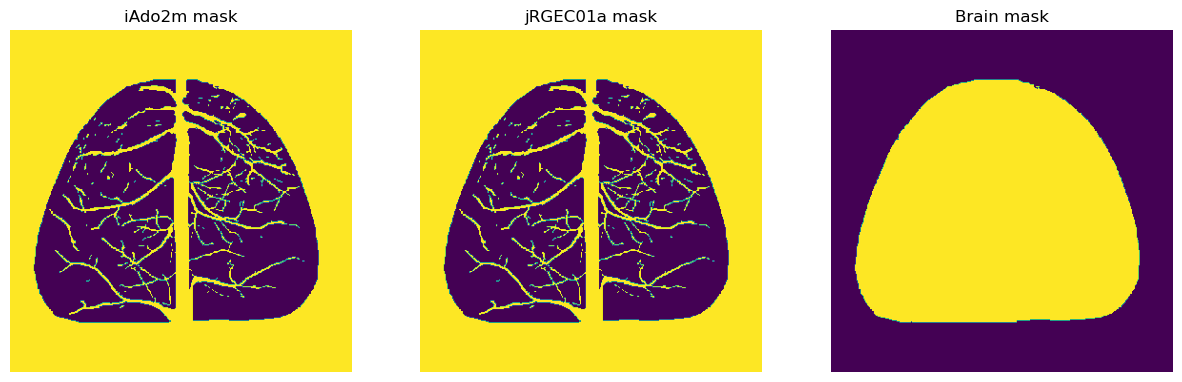

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
iAdo2m_mask = np.isnan(iAdo2m[0])
plt.imshow(iAdo2m_mask)
plt.axis('off')
plt.title('iAdo2m mask')

plt.subplot(132)
jRGEC01a_mask = np.isnan(jRGEC01a[0])
plt.imshow(jRGEC01a_mask)
plt.axis('off')
plt.title('jRGEC01a mask')

# read a mask for inpainting. Here we suggest that you have a mask image of whole object of your imaging
plt.subplot(133)
file_brain_mask = os.path.join(dir_data, 'Mask.tif')
brain_mask = tifffile.imread(file_brain_mask)
plt.imshow(brain_mask)
plt.axis('off')
plt.title('Brain mask')

In the above figure, we showed the pixels with nan values of the iAdo2m and jRGEC01a videos. Some of them are blood vessels and some of them are the pixels outside of the brain. 


Next, we will use one frame as example to show the results of  only inpaint the pixels of blood vessels. 

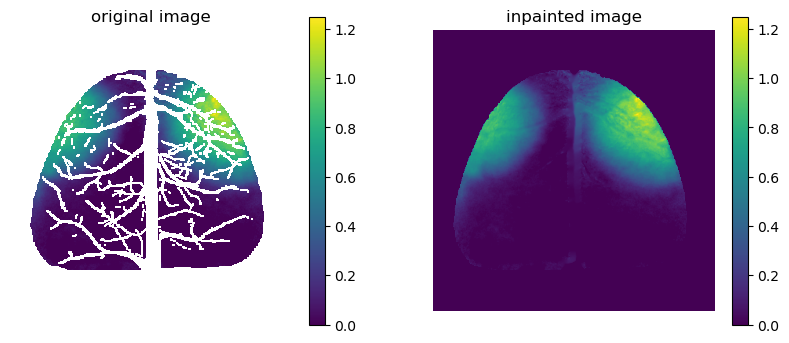

In [11]:
# create a mask for inpainting area
inpaint_mask = np.logical_and(brain_mask, iAdo2m_mask).astype('uint8')

# select one frame and normalize it 
idx_frame = 1150
vmin, vmax = iAdo2m[:, ~iAdo2m_mask].min(), iAdo2m[:, ~iAdo2m_mask].max()
image = ((iAdo2m[idx_frame]-vmin)/(vmax-vmin)*65536).astype(np.uint16)
img_paint = cv2.inpaint(image, 
            inpaint_mask, 
            10, 
            cv2.INPAINT_NS)/65536.0*(vmax-vmin)+vmin 


compare_raw_inpaint(iAdo2m[idx_frame], img_paint)

After inpainting, the whole frames looks natural and smooth, allowing easier the downstream analysis. If you are willing to learn more about the magic behind image inpainting, please refer to the following link: https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html.

In the following we will apply this inpaint to all frames of the iAdo2m and jRGECO1a videos. 

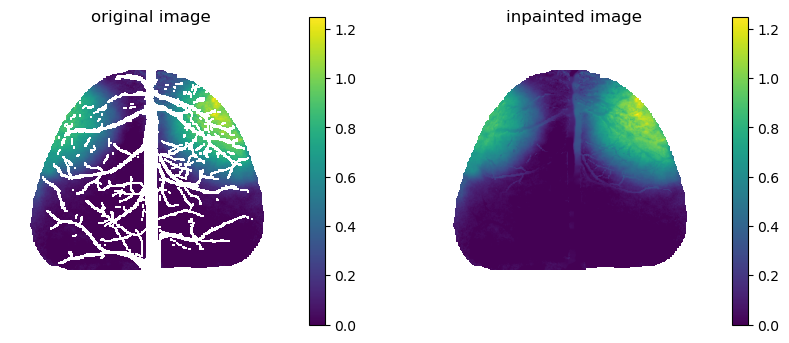

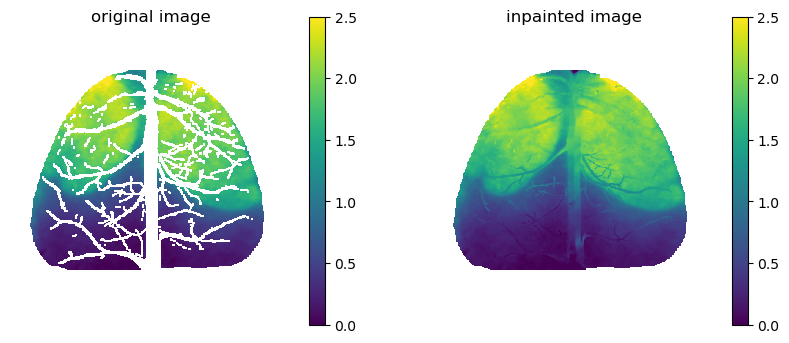

In [13]:
# run inpainting for all frames and save the results to h5 files 
idx_frame = 1150 
with h5py.File(file_iAdo2m_h5, 'a') as h5_iAdo2m:
    if 'iAdo2m_inpaint' not in h5_iAdo2m: 
        iAdo2m_inpaint = inpaint_video(iAdo2m, inpaint_mask, 20, 10)
        h5_iAdo2m.create_dataset('iAdo2m_inpaint', data=iAdo2m_inpaint, chunks=True, compression='gzip')
    
    iAdo2m_inpaint = h5_iAdo2m['iAdo2m_inpaint']
    compare_raw_inpaint(iAdo2m[idx_frame], iAdo2m_inpaint[idx_frame], min_max=[0, 1.25]) 

with h5py.File(file_jRGECO1a_h5, 'a') as h5_jRGECO1a:
    if 'jRGEC01a_inpaint' not in h5_jRGECO1a:
        jRGEC01a_inpaint = inpaint_video(jRGEC01a, inpaint_mask, 20, 10)
        h5_jRGECO1a.create_dataset('jRGEC01a_inpaint', data=jRGEC01a_inpaint, chunks=True, compression='gzip')

    jRGEC01a_inpaint = h5_jRGECO1a['jRGEC01a_inpaint']
    # compare the inpainted video with the original video
    compare_raw_inpaint(jRGEC01a[idx_frame], jRGEC01a_inpaint[idx_frame], min_max=[0, 2.5])

## Step 3: Phase calculation on all pixels

### Compute wave speed given the instantaenously phase 

Suppose we have two pixels, and we know that the wave is propagating from pixel 1 to pixel 2. We can compute the wave speed by measuring the phase differences between the two pixels. If you are not familar with the phase definiton, please check the following wiki page for more information: [phase](https://en.wikipedia.org/wiki/Phase_(waves)) 


Here is the derivation for out calculation of wave speed. 
- At time point $t$, the phases of two pixels are $\phi_1(t)$ and $\phi_2(t)$. Since the wave is propagating from pixel 1 to pixel 2, we know that $\phi_1(t) > \phi_2(t)$. After a small time interval $\Delta t$, the phase of the second pixel $\phi_2(t+\Delta t)$ will be equal to $\phi_1(t)$. In the other word, it takes $\Delta t$ for the wave to travel from pixel 1 to pixel 2. Then the speed  can be easily calculated as 
   $$ \mathbf{v}_{12} = \frac{\Delta \mathbf{s}_{12}}{\Delta t}$$
where $\mathbf{s}_{12}$ is the physical distance between the two pixels.

- The angular velocity is defined as the rate of change of the phase with respect to time, which is given by the derivative of the phase with respect to time. The angular velocity of the wave at pixel 1 is denoted as $w_1(t)$ and at pixel 2 as $w_2(t)$. If the angular velocity of the wave $w(t)$ not changing rapidly, we can approximate $\phi_2(t+\Delta t)$ as $\phi_2(t) + w_2(t)\cdot \Delta t$, then we have 
   $$ \Delta t = \frac{\phi_2(t+\Delta t)-\phi_2(t)}{w_2(t)}=\frac{\phi_1(t)-\phi_2(t)}{w_2(t)}$$
   $w_2(t)$ can be easily computed as the gradient of the instantaneous phase $\phi_2'(t)$.
- Combining the above two equations, we  get  
   $$ \mathbf{v}_{12} = \frac{\Delta \mathbf{s}_{12}\cdot w_2(t)}{\phi_1(t)-\phi_2(t)}$$


From the above equation, we can calculate the wave speed using the instantaneous phase $\phi(t)$ of each pixels, and  $\phi(t)$ at each pixel can be calculated using the Hilbert transform ([read more](https://en.wikipedia.org/wiki/Instantaneous_phase_and_frequency)). 

We also need to convert the phase to be within the range of [-pi, pi].

In [15]:
pos_num = np.asarray(np.nonzero(~np.isnan(iAdo2m[0])))
pos_num_viz = pos_num[[1, 0],:]

with h5py.File(file_iAdo2m_h5, 'a') as h5_iAdo2m:

    if 'iAdo2m_phase' not in h5_iAdo2m: 
        iAdo2m_inpaint = h5_iAdo2m['iAdo2m_inpaint']
        print('Calcualting phase of iAdo2m...')
        iAdo2m_Y_hilbert, iAdo2m_Y_phase = calculate_phase(y=iAdo2m_inpaint[:][:, brain_mask.astype(bool)]).preprocess()
        iAdo2m_phase = np.empty_like(iAdo2m_inpaint[:])
        iAdo2m_phase[:, brain_mask.astype(bool)] = iAdo2m_Y_phase
        h5_iAdo2m.create_dataset('iAdo2m_phase', data=iAdo2m_phase, chunks=True, compression='gzip')
        del iAdo2m_Y_hilbert, iAdo2m_Y_phase
    else: 
        iAdo2m_phase = h5_iAdo2m['iAdo2m_phase']
    
    # convert the phase to [-pi, pi] range
    if 'iAdo2m_phase_mod' not in h5_iAdo2m:
        iAdo2m_phase_mod = np.mod(iAdo2m_phase[:]+np.pi, 2*np.pi) - np.pi
        h5_iAdo2m.create_dataset('iAdo2m_phase_mod', data=iAdo2m_phase_mod, chunks=True, compression='gzip')
    else: 
        iAdo2m_phase_mod = h5_iAdo2m['iAdo2m_phase_mod']

    # segment the wave propagation period 
    if 'iAdo2m_phase_process' not in h5_iAdo2m:
        iAdo2m_phase_process = PhaseProcessor(threshold=0.1, if_vis=False).pixel_phase(iAdo2m_phase[:], pos_num)
        h5_iAdo2m.create_dataset('iAdo2m_phase_process', data=iAdo2m_phase_process, chunks=True, compression='gzip')
    else: 
        iAdo2m_phase_process = h5_iAdo2m['iAdo2m_phase_process']

with h5py.File(file_jRGECO1a_h5, 'a') as h5_jRGECO1a:
    if 'jRGEC01a_phase' not in h5_jRGECO1a:
        jRGEC01a_inpaint = h5_jRGECO1a['jRGEC01a_inpaint']
        print('Calcualting phase of jRGEC01...')
        jRGEC01a_Y_hilbert, jRGEC01a_Y_phase = calculate_phase(y=jRGEC01a_inpaint[:][:, brain_mask.astype(bool)]).preprocess()
        jRGEC01a_phase = np.empty_like(jRGEC01a_inpaint[:])
        jRGEC01a_phase[:, brain_mask.astype(bool)] = jRGEC01a_Y_phase
        h5_jRGECO1a.create_dataset('jRGEC01a_phase', data=jRGEC01a_phase, chunks=True, compression='gzip')
        del jRGEC01a_Y_hilbert, jRGEC01a_Y_phase
    else: 
        jRGEC01a_phase = h5_jRGECO1a['jRGEC01a_phase']

    # convert the phase to [-pi, pi] range
    if 'jRGEC01a_phase_mod' not in h5_jRGECO1a:
        jRGEC01a_phase_mod = np.mod(jRGEC01a_phase[:]+np.pi, 2*np.pi) - np.pi
        h5_jRGECO1a.create_dataset('jRGEC01a_phase_mod', data=jRGEC01a_phase_mod, chunks=True, compression='gzip')
    else: 
        jRGEC01a_phase_mod = h5_jRGECO1a['jRGEC01a_phase_mod']

    # segment the wave propagation period
    if 'jRGEC01a_phase_process' not in h5_jRGECO1a:
        jRGEC01a_phase_process = PhaseProcessor(threshold=0.1, if_vis=False).pixel_phase(jRGEC01a_phase[:], pos_num)
        h5_jRGECO1a.create_dataset('jRGEC01a_phase_process', data=jRGEC01a_phase_process, chunks=True, compression='gzip')
    else: 
        jRGEC01a_phase_process = h5_jRGECO1a['jRGEC01a_phase_process']



In order to maximize the display of phase prominence, the phase will be filtered based on the specific conditions of each pixel(angular frequency).
convert the phase to be within the range of [-pi, pi]

## Step 4: Calculate the wave speed  

Once we have the instaneous phase, we can calculate the wave speed. 

### calculate the wave speed 



In [16]:
wave_start, wave_end = 1050, 1450
if osp.exists(osp.join(dir_results, 'ix.npy')): 
    iAdo2m_ws_vx = np.load(dir_results+ 'ix.npy')
    iAdo2m_ws_vy = np.load(dir_results+ 'iy.npy')
    jRGEC01a_ws_vx = np.load(dir_results+ 'jx.npy')
    jRGEC01a_ws_vy = np.load(dir_results+ 'jy.npy')
else: 
    iAdo2m_ws_vx, iAdo2m_ws_vy, iAdo2m_ws_mag = wave_speed(data=iAdo2m_phase[wave_start:wave_end].copy(), idx=~np.isnan(iAdo2m[0]))
    jRGEC01a_ws_vx, jRGEC01a_ws_vy, jRGEC01a_ws_mag = wave_speed(data=jRGEC01a_phase[wave_start:wave_end].copy(), idx=~np.isnan(jRGEC01a[0]))

    np.save(dir_results+ 'ix.npy', iAdo2m_ws_vx)
    np.save(dir_results+ 'iy.npy', iAdo2m_ws_vy)
    np.save(dir_results+ 'jx.npy', jRGEC01a_ws_vx)
    np.save(dir_results+ 'jy.npy', jRGEC01a_ws_vy)

### visualize wave speed 

After computing the wave speed, we can visualize the wave speed to briefly check the result.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

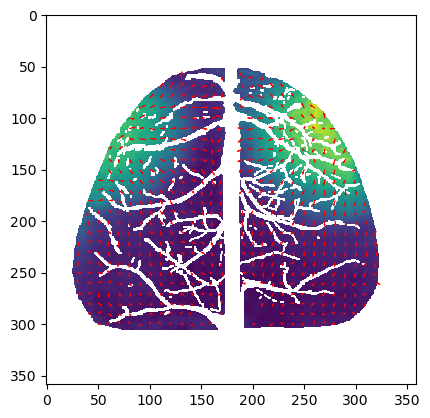

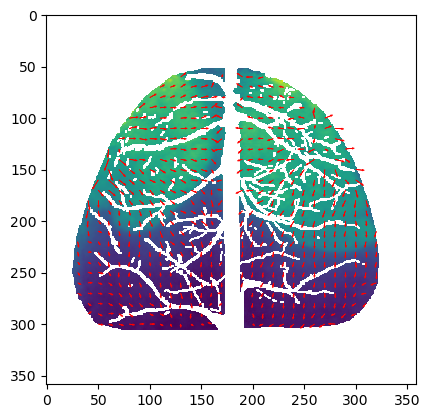

In [21]:
idx_frame = 1150
visualize_wave(image=iAdo2m[idx_frame], idx=100, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy)
visualize_wave(image=jRGEC01a[idx_frame], idx=100, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy)

The above images showed the velocity of the wave in one frame. We can perform this visualization for all frames and then save the results to a video file.

In [59]:
# make quiver videos
h, w = iAdo2m[0].shape
step = 10
points = []
for i in range(0, h, step): 
    for j in range(0, w, step): 
        if ~np.isnan(iAdo2m[0, i,j]):
            points.append((i, j))
print(points)

quiver_video(iAdo2m, iAdo2m_ws_vx, iAdo2m_ws_vy, osp.join(dir_results,  'iAdo2m_quiver.mp4'), points)
quiver_video(jRGEC01a, jRGEC01a_ws_vx, jRGEC01a_ws_vy, osp.join(dir_results, 'jRGEC01a_quiver.mp4'), points)

[(60, 130), (60, 170), (60, 190), (60, 200), (60, 210), (70, 110), (70, 120), (70, 130), (70, 140), (70, 150), (70, 160), (70, 190), (70, 200), (70, 210), (70, 220), (70, 230), (80, 100), (80, 110), (80, 120), (80, 130), (80, 140), (80, 150), (80, 160), (80, 170), (80, 190), (80, 200), (80, 210), (80, 220), (80, 230), (80, 240), (90, 90), (90, 100), (90, 110), (90, 120), (90, 130), (90, 140), (90, 150), (90, 160), (90, 170), (90, 190), (90, 220), (90, 230), (90, 250), (90, 260), (100, 80), (100, 90), (100, 110), (100, 130), (100, 140), (100, 150), (100, 160), (100, 170), (100, 200), (100, 210), (100, 220), (100, 240), (100, 250), (100, 260), (100, 270), (110, 80), (110, 90), (110, 100), (110, 110), (110, 120), (110, 130), (110, 140), (110, 150), (110, 170), (110, 190), (110, 200), (110, 220), (110, 230), (110, 240), (110, 250), (110, 260), (110, 270), (110, 280), (120, 70), (120, 80), (120, 90), (120, 100), (120, 110), (120, 120), (120, 130), (120, 150), (120, 160), (120, 170), (120, 1

The above visualization only displayed the speed at selected pixels. If we want to visualize the speed at all pixels, we can use color to encode the speed with a colormap. 

In [24]:
def save_flow(wave_x, wave_y):
    wave_x = torch.from_numpy(wave_x.astype('float32')).unsqueeze(0)
    wave_y = torch.from_numpy(wave_y.astype('float32')).unsqueeze(0)
    wave = torch.cat((wave_x, wave_y), dim=0)

    return (flow_to_image(wave)*255).astype('uint8')

iAdo2m_flow, jRGEC01a_flow = [], []

for i in range(iAdo2m_ws_vx.shape[0]):
    iAdo2m_flow.append(save_flow(iAdo2m_ws_vx[i], iAdo2m_ws_vy[i]))

for i in range(jRGEC01a_ws_vx.shape[0]):
    jRGEC01a_flow.append(save_flow(jRGEC01a_ws_vx[i], jRGEC01a_ws_vy[i]))

# # make flow videos
generate_video(iAdo2m_flow, output_file=osp.join(dir_results, 'iAdo2m_flow.mp4'), fps=20)
generate_video(jRGEC01a_flow, output_file=osp.join(dir_results, 'jRGEC01a_flow.mp4'), fps=20)

Video is finished.
Video is finished.


### histogram of the wave speed 

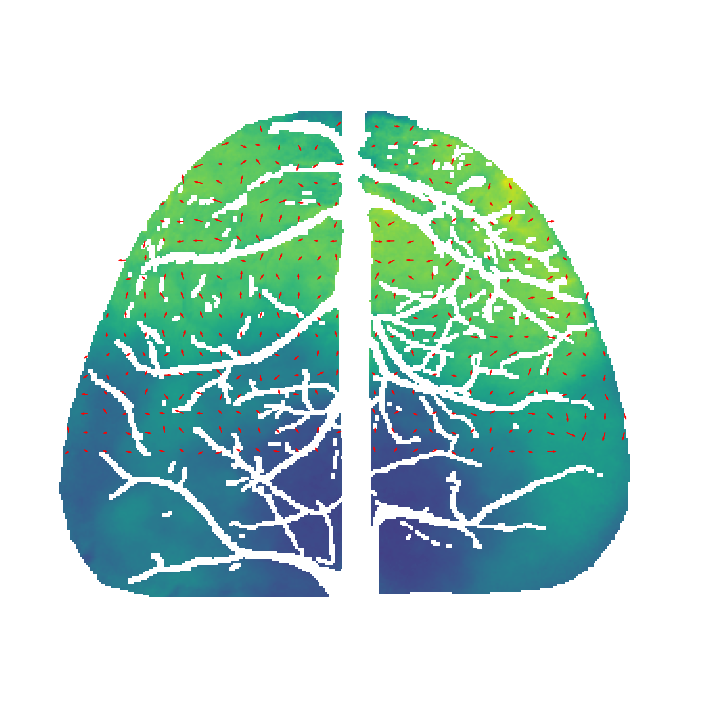

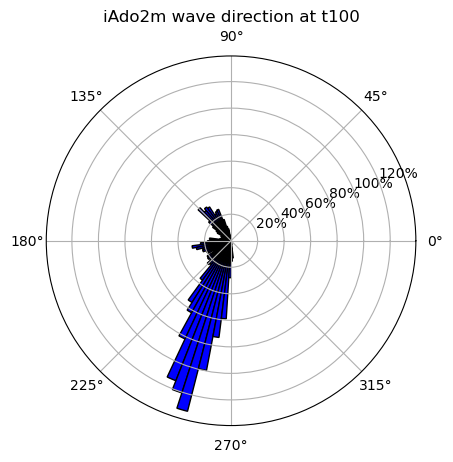

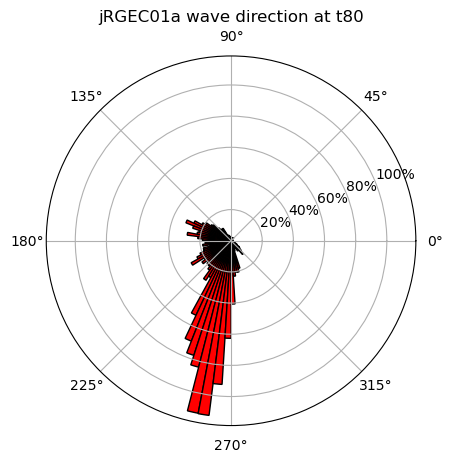

In [25]:
# make polar histgram video
polar_hist(iAdo2m_ws_vx[100,70:180,220:300], -iAdo2m_ws_vy[100,70:180,220:300], idx=100, color='blue', thres=2, title_name='iAdo2m', save=False)
polar_hist(jRGEC01a_ws_vx[80,70:180,220:300], -jRGEC01a_ws_vy[80,70:180,220:300], idx=80, color='red', thres=2, title_name='jRGEC01a', save=False)

we can display the histogram for all frames and make a gif. 

In [60]:
total_filtered_theta1, current_frame_data_percentage1, total_len1 = pre_hist(iAdo2m_ws_vx[:,70:180,220:300], -iAdo2m_ws_vy[:,70:180,220:300], thres=2)
total_filtered_theta2, current_frame_data_percentage2, total_len2 = pre_hist(jRGEC01a_ws_vx[:,70:180,220:300], -jRGEC01a_ws_vy[:,70:180,220:300], thres=2)

# Generate frames for the MP4 animation
polar_hist = []
for i in range(300):
    polar_hist.append(polar_hist_mp4(total_filtered_theta1, total_filtered_theta2, current_frame_data_percentage1, current_frame_data_percentage2, 
                                     idx=i, frame_number=i+1050, color1='blue', color2='red'))

# Write frames to an MP4 file
with imageio.get_writer(osp.join(dir_results, 'polar_hist.gif'), mode='I', fps=15) as writer:
    for frame in polar_hist:
        writer.append_data(frame)

## Step 5: Statistical analysis of speed

Make a histogram of the wave speed. 

<Figure size 1400x500 with 0 Axes>

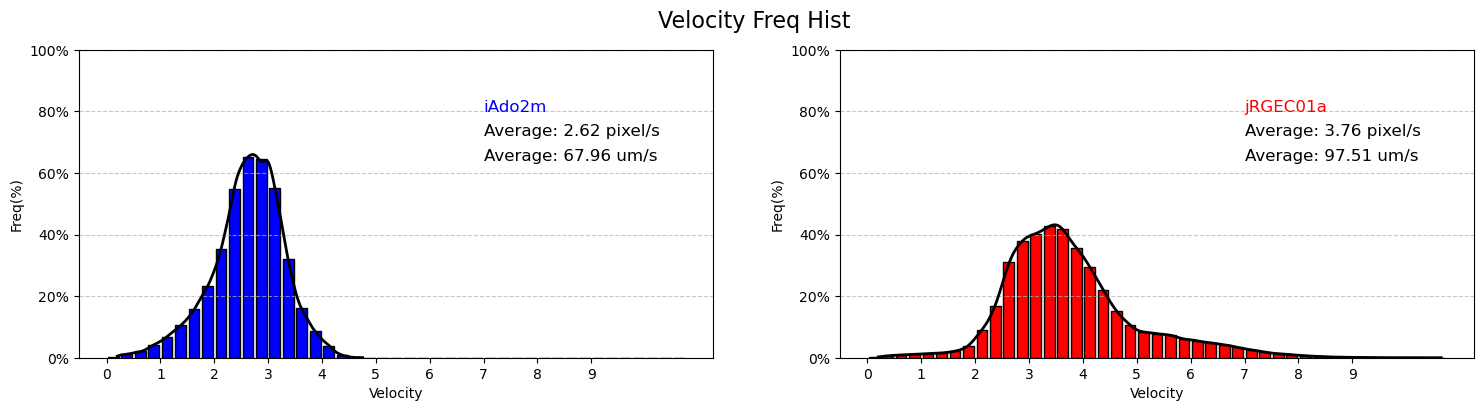

In [27]:
iAdo2m_vel = np.sqrt(iAdo2m_ws_vx**2 + iAdo2m_ws_vy**2)
jRGEC01a_vel = np.sqrt(jRGEC01a_ws_vx**2 + jRGEC01a_ws_vy**2)

plt.figure(figsize=(18, 4))
plt.subplot(121)
data1 = iAdo2m_vel[70:100, 50:200, 200:300].flatten()
data1 = data1[data1>0.2]
plt.hist(data1, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='blue', edgecolor='black', density=True)
kde1 = stats.gaussian_kde(data1)
x1 = np.linspace(min(data1), max(data1), 1000)
plt.plot(x1, kde1(x1), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean1 = np.mean(data1)
plt.text(7, 0.72, f'Average: {mean1:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.64, f'Average: {(mean1*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.8, 'iAdo2m', fontsize=12, color='blue')

plt.subplot(122)
data2 = jRGEC01a_vel[70:100, 50:200, 200:300].flatten()
data2 = data2[data2>0.2]
plt.hist(data2, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='red', edgecolor='black', density=True)
kde2 = stats.gaussian_kde(data2)
x2 = np.linspace(min(data2), max(data2), 1000)
plt.plot(x2, kde2(x2), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean2 = np.mean(data2)
plt.text(7, 0.72, f'Average: {mean2:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.64, f'Average: {(mean2*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.8, 'jRGEC01a', fontsize=12, color='red')

plt.suptitle('Velocity Freq Hist', fontsize=16)
plt.show()

Put the hists together to better visualize the differences. 

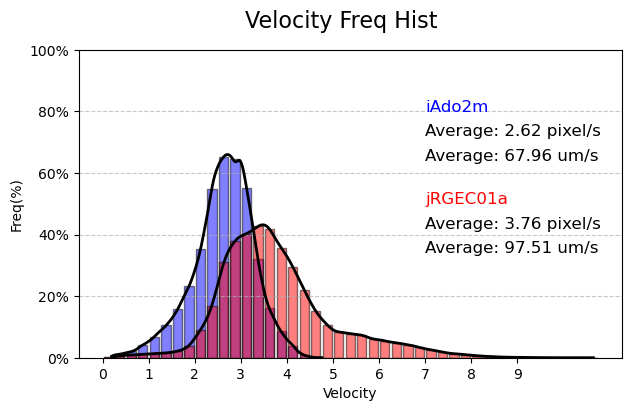

In [28]:
plt.figure(figsize=(7, 4))
data1 = iAdo2m_vel[70:100, 50:200, 200:300].flatten()
data1 = data1[data1>0.2]
plt.hist(data1, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='blue', edgecolor='black', density=True, alpha=0.5)
kde1 = stats.gaussian_kde(data1)
x1 = np.linspace(min(data1), max(data1), 1000)
plt.plot(x1, kde1(x1), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean1 = np.mean(data1)
plt.text(7, 0.72, f'Average: {mean1:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.64, f'Average: {(mean1*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.8, 'iAdo2m', fontsize=12, color='blue')

data2 = jRGEC01a_vel[70:100, 50:200, 200:300].flatten()
data2 = data2[data2>0.2]
plt.hist(data2, bins=np.arange(0, 11, 0.25), rwidth=0.8, color='red', edgecolor='black', density=True, alpha=0.5)
kde2 = stats.gaussian_kde(data2)
x2 = np.linspace(min(data2), max(data2), 1000)
plt.plot(x2, kde2(x2), color='black', linewidth=2)

plt.xticks(range(10))
plt.xlabel('Velocity')
plt.ylabel('Freq(%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylim(0, 1.0)

mean2 = np.mean(data2)
plt.text(7, 0.42, f'Average: {mean2:.2f} pixel/s', fontsize=12, color='black')
plt.text(7, 0.34, f'Average: {(mean2*25.9):.2f} um/s', fontsize=12, color='black')
plt.text(7, 0.5, 'jRGEC01a', fontsize=12, color='red')

plt.suptitle('Velocity Freq Hist', fontsize=16)
plt.show()

## Origin analysis 

We want to find the origin of the wave. 


First, we use the modulated phases to calculate the original regions based on the specific temporal patterns. 

In [31]:
with h5py.File(file_iAdo2m_h5, 'r') as h5_iAdo2m: 
    iAdo2m_phase_mod = h5_iAdo2m['iAdo2m_phase_mod']
    iAdo2m_phase_origin = find_original(iAdo2m_phase_mod[:], fix=iAdo2m, hmin=50, hmax=320, wmin=180, wmax=330, 
                                        sign='iAdo2m', continue_t_len_down=300, continue_t_len_up=None)

with h5py.File(file_jRGECO1a_h5, 'r') as h5_jRGEC01a:
    jRGEC01a_phase_mod = h5_jRGEC01a['jRGEC01a_phase_mod']
    jRGEC01a_phase_origin = find_original(jRGEC01a_phase_mod[:], fix=jRGEC01a, hmin=50, hmax=320, wmin=180, wmax=330, 
                                        sign='jRGEC01a', continue_t_len_down=800, continue_t_len_up=1100)

The found origins may look noisy. We utilize a cluster algorithm to find the most probable regions. 

iAdo2m original point: [[101 271]
 [101 272]
 [105 272]
 [105 273]
 [105 276]]
jRGEC01a original points: (array([[ 78, 241],
       [ 80, 238],
       [ 81, 239],
       [ 81, 240],
       [ 81, 241],
       [ 82, 240],
       [ 82, 241],
       [ 83, 241]]), array([[137, 291],
       [137, 292],
       [139, 297],
       [140, 297]]))


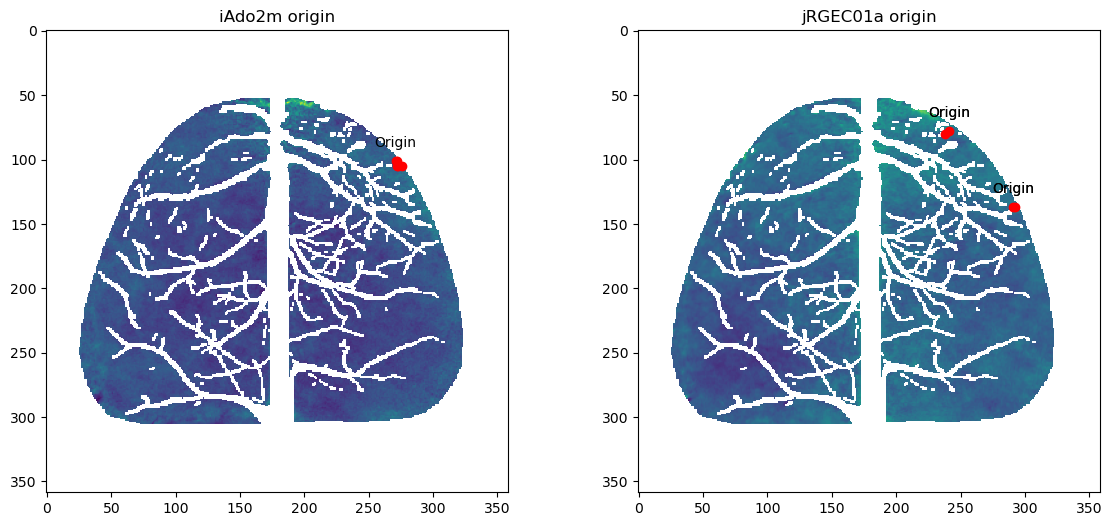

In [33]:
iAdo2m_phase_origin_region = select_origin_region(iAdo2m_phase_origin, radius=10, method='hierarchy', wave_num=1)
jRGEC01a_phase_origin_region = select_origin_region(jRGEC01a_phase_origin, radius=10, method='hierarchy', wave_num=2)
print("iAdo2m original point:", iAdo2m_phase_origin_region)
print("jRGEC01a original points:", jRGEC01a_phase_origin_region)

top_k = len(iAdo2m_phase_origin_region)
wave_num = 1
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(iAdo2m[0])
for k in range(top_k):
    plt.scatter(x=iAdo2m_phase_origin_region[k][1], y=iAdo2m_phase_origin_region[k][0], c='red')
plt.annotate(f'Origin', (iAdo2m_phase_origin_region[0,1], iAdo2m_phase_origin_region[0,0]), textcoords='offset points', xytext=(0,10), ha='center')
plt.title('iAdo2m origin')
top_k = len(jRGEC01a_phase_origin_region)
wave_num = 2
plt.subplot(122)
plt.imshow(jRGEC01a[0])
for i in range(wave_num):
    for k in range(top_k):
        plt.scatter(x=jRGEC01a_phase_origin_region[i][k][1], y=jRGEC01a_phase_origin_region[i][k][0], c='red')
        plt.annotate('Origin', (jRGEC01a_phase_origin_region[i][0,1], jRGEC01a_phase_origin_region[i][0,0]), textcoords='offset points', xytext=(0,10), ha='center')
plt.title('jRGEC01a origin')
plt.show()

One advantage this analysis is that it allows more than 1 (<=3) wave origin. Later, we used the center points of these origins as the wave origin. 

jRGEC01a wave


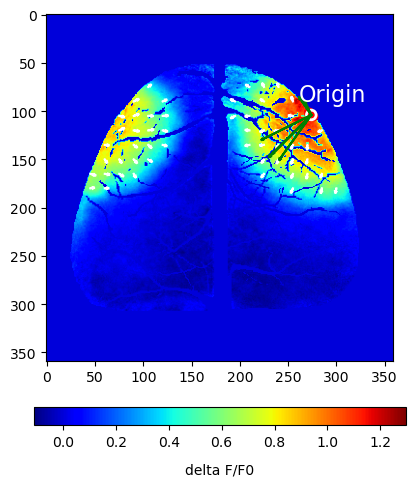

jRGEC01a wave


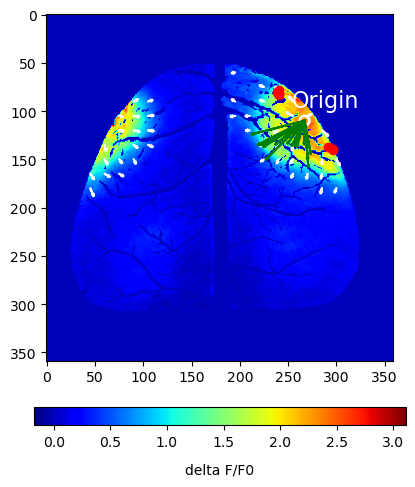

In [ ]:
with h5py.File(file_iAdo2m_h5, 'r') as h5_iAdo2m: 
    iAdo2m_phase = h5_iAdo2m['iAdo2m_phase'][:]

with h5py.File(file_jRGECO1a_h5, 'r') as h5_jRGEC01a:
    jRGEC01a_phase = h5_jRGEC01a['jRGEC01a_phase'][:]

print('iADO wave')
vis_wave(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy, origin_region=iAdo2m_phase_origin_region, wave_num=1, 
         phase_step=1, title_name='iAdo2m', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)

print('jRGEC01a wave')
vis_wave(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy, origin_region=jRGEC01a_phase_origin_region, wave_num=2, 
        phase_step=1, title_name='jRGEC01a', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)

Visualize in a local view as well. 

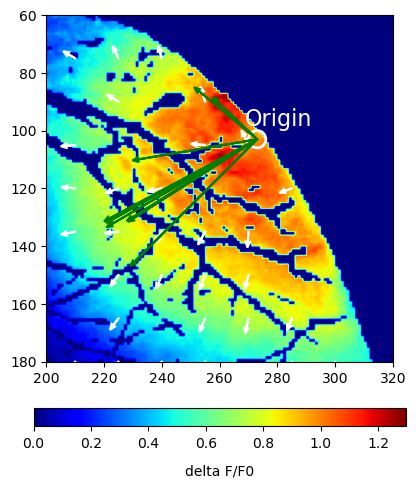

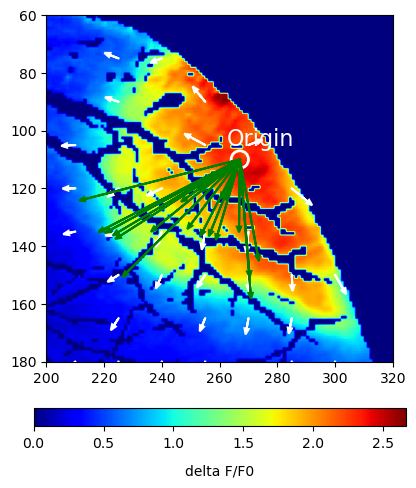

In [53]:
from functions import *
center_x_iAdo2m, center_y_iAdo2m = vis_wave_local(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy, origin_region=iAdo2m_phase_origin_region, wave_num=1,  
                                                  phase_step=10, title_name='iAdo2m', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)
center_x_jRGEC01a, center_y_jRGEC01a = vis_wave_local(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy, origin_region=jRGEC01a_phase_origin_region, wave_num=2, 
                                                  phase_step=10, title_name='jRGEC01a', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)

Later, if you would like to visualize your waves in a fixed original center across different videos, you can align the center and reset your origins. 

In [54]:
center_x_align, center_y_align, _ = min_circle(np.asarray([[center_x_iAdo2m, center_y_iAdo2m], [center_x_jRGEC01a, center_y_jRGEC01a]]))
print(int(center_x_align), int(center_y_align))

270 106


The origins and arrows can be visualize based on your aligned centers and velocity arrows you have calculated. 

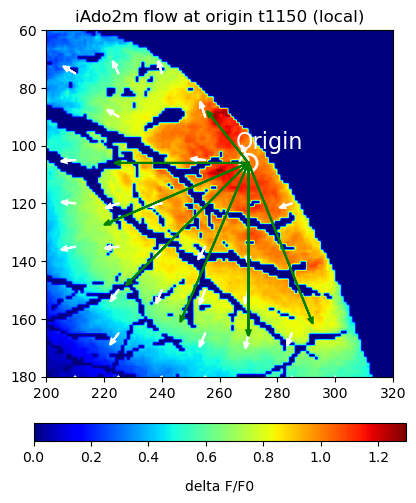

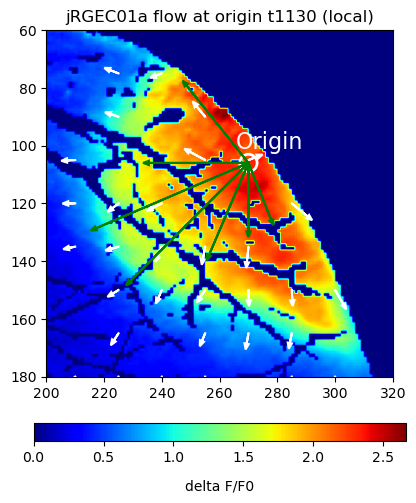

In [56]:
vis_wave_local_direct(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy, center_x=center_x_align, center_y=center_y_align,  
                      phase_step=10, title_name='iAdo2m', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)
vis_wave_local_direct(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy,  center_x=center_x_align, center_y=center_y_align, 
                      phase_step=10, title_name='jRGEC01a', thre=2, linewidth=1.5, save=True, quiver_thre=1e-5)

The visualization of wave origins can be much stricter by even fixing the arrows with standard numeric values. This visualization could be neat, but we suggest that you use the 'direct' way to see the outcomes. 

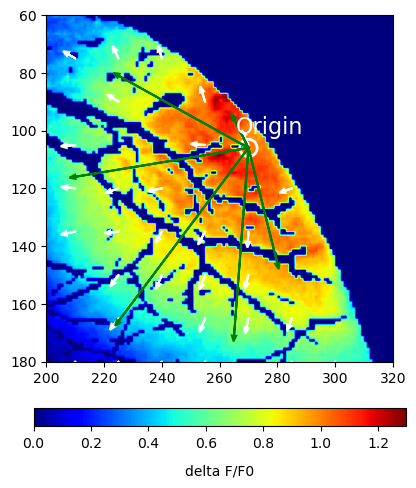

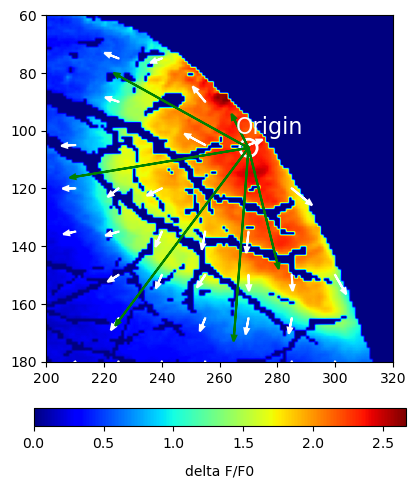

In [58]:
vis_wave_local_standard(iAdo2m, iAdo2m_phase, idx=100, step=15, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy, center_x=center_x_align, center_y=center_y_align,  
                      phase_step=10, title_name='iAdo2m', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)
vis_wave_local_standard(jRGEC01a, jRGEC01a_phase, idx=80, step=15, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy,  center_x=center_x_align, center_y=center_y_align, 
                      phase_step=10, title_name='jRGEC01a', thre=2, linewidth=1.5, save=False, quiver_thre=1e-5)

That is the end of our demo. Hope you find something insightful. 

----------

## Thanks for your time 

We are looking forward to continuous contribution. 

@ Shiyi Ding, Pengcheng Zhou